In [1]:
%matplotlib inline
from __future__ import division
from osgeo import gdal
import numpy as np
import scipy.signal
import os
import matplotlib.pyplot as plt
import nitime.algorithms as tsa

Define three functions. First the conversion to scale the graph to 10log10 aka decibel. Second the multitaper estimation method to compute the psd, csd, coherence and phase spectrum. Third is the uncertainty of the phase spectrum based on a monte carlo analysis method

In [2]:
def dB(x, out=None):
    if out is None:
        return 10 * np.log10(x)
    else:
        np.log10(x, out)
        np.multiply(out, 10, out)

def mtem(x, y, dt):
    """
    multitaper estimation method
    input:
    x  first time series
    y  second time series

    output:
    fkx  power spectral density x
    fky  power spectral density y
    cxy  cross-spectral density xy
    coh  coherence
    ph  phase between xy at input freq
    
    """
    print 'x size', x.shape
    print 'y size', y.shape
    
    # apply multi taper cross spectral density from nitime module
    f, pcsd_est = tsa.multi_taper_csd(np.vstack([x,y]), Fs=1/dt, low_bias=True, adaptive=True, sides='onesided')
    
    # output is MxMxN matrix, extract the psd and csd
    fkx = pcsd_est.diagonal().T[0]
    fky = pcsd_est.diagonal().T[1]
    cxy = pcsd_est.diagonal(+1).T.ravel()
    
    # using complex argument of cxy extract phase component
    ph = np.angle(cxy)
    
    # calculate coherence using csd and psd
    coh = np.abs(cxy)**2 / (fkx * fky)   
    
    return f, fkx, fky, cxy, ph, coh 

def mtem_unct(x_, y_, dt_, cf, mc_no=20):
    """
    Uncertainty function using Monte Carlo analysis
    Input:
    x_ = timeseries x
    y_ = timeseries y
    cf = coherence function between x and y
    mc_no = number of iterations default is 20, minimum is 3
    
    Output:
    phif = phase uncertainty bounded between 0 and pi
    """
    print 'iteration no is', mc_no
    
    data = np.vstack([x_,y_])
    # number of iterations
    # flip coherence and horizontal stack    
    cg = np.hstack((cf[:-1], np.flipud(cf[:-1])))
    
    # random time series fx
    mc_fx = np.random.standard_normal(size=(mc_no,len(data[0])))
    mc_fx = mc_fx / np.sum(abs(mc_fx),axis=1)[None].T
    
    # random time series fy
    mc_fy = np.random.standard_normal(size=(mc_no,len(data[0])))
    mc_fy = mc_fy / np.sum(abs(mc_fy),axis=1)[None].T
    
    # create semi random timeseries based on magnitude squared coherence
    # and inverse fourier transform for ys
    ys = np.real(np.fft.ifft(mc_fy * np.sqrt(1 - cg ** 2))) 
    ys = ys + np.real(np.fft.ifft(mc_fx *cg))
    
    # inverse fourier transform for xs
    xs = np.real(np.fft.ifft(mc_fx))
    
    # spectral analysis
    f_s, pcsd_est = tsa.multi_taper_csd(np.vstack([xs,ys]), Fs=1/dt_, low_bias=True, adaptive=True, sides='onesided')
    cxyi = pcsd_est.diagonal(+int(xs.shape[0])).T
    phi = np.angle(cxyi)
    
    # sort and average the highest uncertianties
    pl = int(round(0.975*mc_no)+1)
    phi = np.sort(phi,axis=0)        
    phi = phi[((mc_no+1)-pl):pl]
    phi = np.array([phi[pl-2,:],-phi[pl-mc_no,:]])
    phi = phi.mean(axis=0)#
    phi = np.convolve(phi, np.array([1,1,1])/3)
    phif = phi[1:-1]
    return phif


Extract timeseries from satellite imagery

In [3]:
# # import numpy as np
# # import matplotlib.pyplot as plt

# # # make a little extra space between the subplots
# # plt.subplots_adjust(wspace=0.5)

# # nfft = 256
# dt = 0.01
# t = np.arange(0, 30, dt)
# nse1 = np.random.randn(len(t))                 # white noise 1
# nse2 = np.random.randn(len(t))                 # white noise 2
# r = np.exp(-t/0.05)

# cnse1 = np.convolve(nse1, r, mode='same')*dt   # colored noise 1
# cnse2 = np.convolve(nse2, r, mode='same')*dt   # colored noise 2

# # two signals with a coherent part and a random part
# x = 0.01*np.sin(2*np.pi*10*t) + cnse1
# y = 0.01*np.sin(2*np.pi*10*t) + cnse2

In [4]:
end = 2000
dt=1
t = np.arange(0,end,dt)
# pi_plu = np.full(len(t), np.pi)
# pi_min = np.full(len(t), -np.pi)
rand1 = np.random.rand(end)
rand2 = np.random.rand(end)
x = 1*np.cos(2*np.pi*90/360+2*np.pi/21*t)+4*np.cos(+2*np.pi*10/360-2*np.pi/10*t)+1.5*(-1+2*rand1)
y = 1*np.cos(2*np.pi*60/360+2*np.pi/21*t)+4*np.cos(-2*np.pi*70/360-2*np.pi/10*t)+1.5*(-1+2*rand2)
# plt.plot(t,x_1)
# plt.plot(t,y_1)
# plt.xlim([0,100])

In [79]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

plt.rc('font', **font)

Plot the two timeseries as is

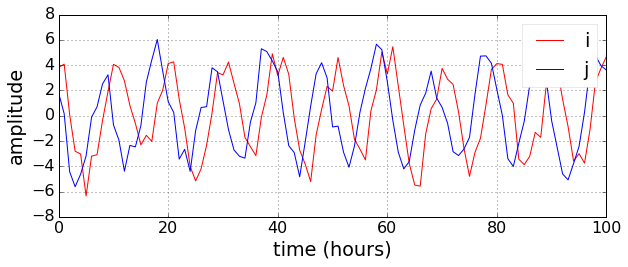

In [104]:
plt.figure(figsize=(9,4))
plt.subplot(111)
plt.grid()

plt.plot(t,x, 'r', lw=1, label='i')
plt.plot(t,y, 'b', lw=1, label='j')
plt.xlim(0,100)

plt.ylabel('amplitude')
plt.xlabel('time (hours)')
lg = plt.legend()
lg.get_frame().set_ec('lightgray')
lg.get_frame().set_lw(0.5)

plt.gcf().tight_layout()
plt.savefig(r'C:\Users\lenovo.lenovo-PC.000\Documents\images_oral_defense//series_x_y.png', dpi=400)

Compute all the components we need: frequencies, power spectral density of x, power spectral density of y, cross spectral density between x and y, coherence between x and y, phase spectrum between x and y and last the phase uncertainty between x and y.

In [82]:
f, fkx, fky, cxy, ph, coh = mtem(x,y,dt)
phif = mtem_unct(x,y,dt,coh, mc_no=10)

x size (2000L,)
y size (2000L,)
iteration no is 10


In [83]:
vspan_start1 = 0.0465
vspan_end1 = 0.0485
vspan_start2 = 0.099
vspan_end2 = 0.101
xlim_start = 0.000
xlim_end = 0.25

So now only making some plots of the result. First the psd of x and y.

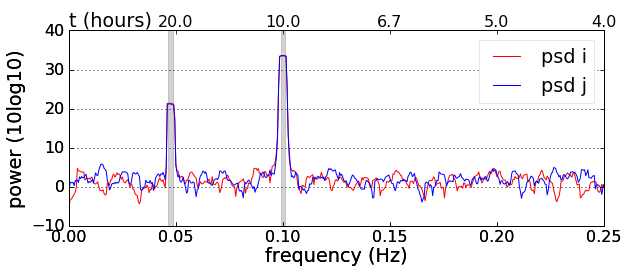

In [115]:
plt.figure(figsize=(9,4))
plt.rcParams.update({'axes.labelsize': 'large'})
ax = host_subplot(111, axes_class=AA.Axes)

# aiaiaiai
ax.set_xlim([xlim_start,xlim_end])
ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('phase (day)')
ax.set_title('t (hours)', loc='left')

ax2 = ax.twin() # ax2 is responsible for "top" axis and "right" axis
#ax2.set_xlabel('The Dependence of Phase-Delay on Frequency and Time (+ Phase Uncertainty Estimates via Monte Carlo Analysis)')
ax2.set_xticks([(0.05),(0.1),(0.15),(0.2), (0.25)])#0., .5*np.pi, np.pi, 1.5*np.pi, 2*np.pi])
ax2.set_xticklabels([str(1./0.05),str(1./0.1),str(round(1./0.15,1)),str(1./0.2),str(1./0.25)])
ax2.axis["right"].major_ticklabels.set_visible(False)

ax.grid(axis='y')
#ax.plot(f,dB(cxy), 'g-', lw=1, label='csd xy')
ax.plot(f,dB(fkx), 'r-', lw=1, label ='psd i')
ax.plot(f,dB(fky), 'b-', lw=1, label='psd j')
plt.axvspan(vspan_start1,vspan_end1, color='gray', alpha=0.35)
plt.axvspan(vspan_start2,vspan_end2, color='gray', alpha=0.35)
plt.ylim(-10,40)

ax.set_ylabel('power (10log10)') # regex: ($10log10$)
ax.set_xlabel('frequency (Hz)')
#ax.set_title('cross spectral density of x and y')
# ax.set_yscale('symlog')
lg = plt.legend()
lg.get_frame().set_ec('lightgray')
lg.get_frame().set_lw(0.5)

plt.gcf().tight_layout()
plt.savefig(r'C:\Users\lenovo.lenovo-PC.000\Documents\images_oral_defense//psd_x_y.png', dpi=400)

Timeseries of x contains noise and two components relating to frequency 0.1 and 0.047 Hz. Psd of y only contains one component related to frequency 0.1 Hz. Next we plot the cross spectral density and the corresponding coherence, which is the normalised csd.

In [85]:
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA

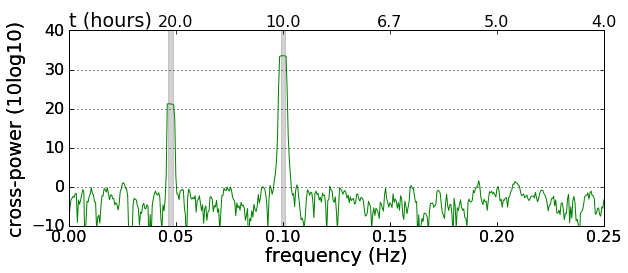

In [108]:
plt.figure(figsize=(9,4))
plt.rcParams.update({'axes.labelsize': 'large'})
ax = host_subplot(111, axes_class=AA.Axes)

# aiaiaiai
ax.set_xlim([xlim_start,xlim_end])
ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('phase (day)')
ax.set_title('t (hours)', loc='left')

ax2 = ax.twin() # ax2 is responsible for "top" axis and "right" axis
#ax2.set_xlabel('The Dependence of Phase-Delay on Frequency and Time (+ Phase Uncertainty Estimates via Monte Carlo Analysis)')
ax2.set_xticks([(0.05),(0.1),(0.15),(0.2), (0.25)])#0., .5*np.pi, np.pi, 1.5*np.pi, 2*np.pi])
ax2.set_xticklabels([str(1./0.05),str(1./0.1),str(round(1./0.15,1)),str(1./0.2),str(1./0.25)])
ax2.axis["right"].major_ticklabels.set_visible(False)

ax.grid(axis='y')
ax.plot(f,dB(cxy), 'g-', lw=1, label='csd xy')
plt.axvspan(vspan_start1,vspan_end1, color='gray', alpha=0.35)
plt.axvspan(vspan_start2,vspan_end2, color='gray', alpha=0.35)
plt.ylim(-10,40)

ax.set_ylabel('cross-power (10log10)') # regex: ($10log10$)
ax.set_xlabel('frequency (Hz)')
#ax.set_title('cross spectral density of x and y')
# ax.set_yscale('symlog')
# plt.legend()
plt.gcf().tight_layout()
plt.savefig(r'C:\Users\lenovo.lenovo-PC.000\Documents\images_oral_defense//csd_x_y.png', dpi=400)

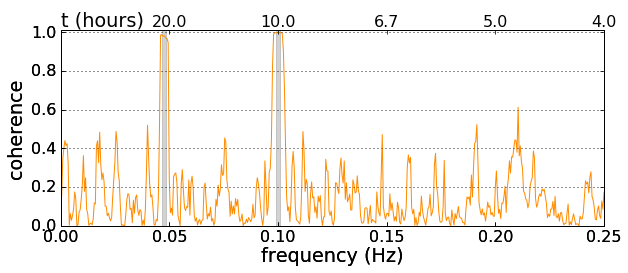

In [109]:
plt.figure(figsize=(9,4))
plt.rcParams.update({'axes.labelsize': 'large'})
ax = host_subplot(111, axes_class=AA.Axes)

ax.set_xlim([xlim_start,xlim_end])
ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('phase (day)')
ax.set_title('t (hours)', loc='left')

ax2 = ax.twin() # ax2 is responsible for "top" axis and "right" axis
ax2.set_xticks([(0.05),(0.1),(0.15),(0.2), (0.25)])#0., .5*np.pi, np.pi, 1.5*np.pi, 2*np.pi])
ax2.set_xticklabels([str(1./0.05),str(1./0.1),str(round(1./0.15,1)),str(1./0.2),str(1./0.25)])
ax2.axis["right"].major_ticklabels.set_visible(False)

# plt.subplot(122)
ax.grid(axis='y')
ax.set_ylim([0,1.01])
ax.plot(f,coh, 'darkorange', label='coherence xy')

plt.axvspan(vspan_start1,vspan_end1, color='gray', alpha=0.35)
plt.axvspan(vspan_start2,vspan_end2, color='gray', alpha=0.35)
ax.set_xlim(xlim_start,xlim_end)
# plt.ylim(0,1.01)

ax.set_ylabel('coherence')
ax.set_xlabel('frequency (Hz)')
#ax.set_title()

plt.gcf().tight_layout()
# plt.legend()
plt.savefig(r'C:\Users\lenovo.lenovo-PC.000\Documents\images_oral_defense//coherence_x_y.png', dpi=400)

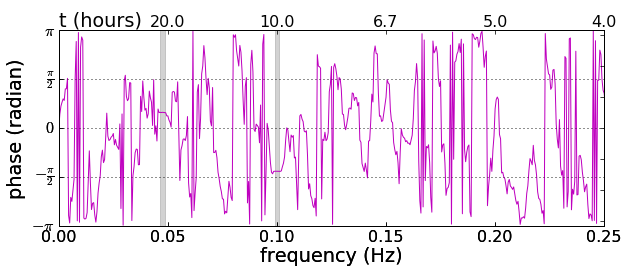

In [110]:
plt.figure(figsize=(9,4))
plt.rcParams.update({'axes.labelsize': 'large'})
ax = host_subplot(111, axes_class=AA.Axes)

ax.set_xlim([xlim_start,xlim_end])
ax.set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
ax.set_yticklabels(['$-\pi$', r'$-\frac{\pi}{2}$', r'$0$', r'$\frac{\pi}{2}$', r'$\pi$'])

ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('phase (radian)')
ax.set_title('t (hours)', loc='left')

ax2 = ax.twin() # ax2 is responsible for "top" axis and "right" axis
#ax2.set_xlabel('The Dependence of Phase-Delay on Frequency and Time (+ Phase Uncertainty Estimates via Monte Carlo Analysis)')
ax2.set_xticks([(0.05),(0.1),(0.15),(0.2), (0.25)])#0., .5*np.pi, np.pi, 1.5*np.pi, 2*np.pi])
ax2.set_xticklabels([str(1./0.05),str(1./0.1),str(round(1./0.15,1)),str(1./0.2),str(1./0.25)])
ax2.axis["right"].major_ticklabels.set_visible(False)
ax.grid(axis='y')

plt.axvspan(vspan_start1,vspan_end1, color='gray', alpha=0.35)
plt.axvspan(vspan_start2,vspan_end2, color='gray', alpha=0.35)

ax.set_xlim(xlim_start,xlim_end)
ax.set_ylim(-np.pi,np.pi)

plt.plot(f,ph, 'm', label='phase xy')

#plt.title('phase between x and y for all frequencies + uncertainty')
plt.gcf().tight_layout()
plt.savefig(r'C:\Users\lenovo.lenovo-PC.000\Documents\images_oral_defense//phase_x_y.png', dpi=400)

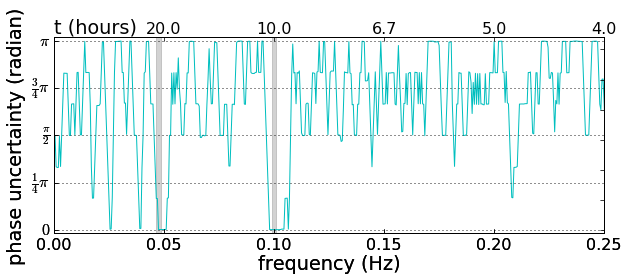

In [111]:
plt.figure(figsize=(9,4))
plt.rcParams.update({'axes.labelsize': 'large'})
ax = host_subplot(111, axes_class=AA.Axes)

ax.set_xlim([xlim_start,xlim_end])
ax.set_yticks([0,1./4*np.pi, np.pi/2, 3./4*np.pi,np.pi])
ax.set_yticklabels([r'$0$', r'$\frac{1}{4}\pi$', r'$\frac{\pi}{2}$', r'$\frac{3}{4}\pi$', 
                     r'$\pi$'])

ax.set_ylabel('phase uncertainty (radian)')
ax.set_xlabel('frequency (Hz)')
ax.set_title('t (hours)', loc='left')

ax2 = ax.twin() # ax2 is responsible for "top" axis and "right" axis
#ax2.set_xlabel('The Dependence of Phase-Delay on Frequency and Time (+ Phase Uncertainty Estimates via Monte Carlo Analysis)')
ax2.set_xticks([(0.05),(0.1),(0.15),(0.2), (0.25)])#0., .5*np.pi, np.pi, 1.5*np.pi, 2*np.pi])
ax2.set_xticklabels([str(1./0.05),str(1./0.1),str(round(1./0.15,1)),str(1./0.2),str(1./0.25)])
ax2.axis["right"].major_ticklabels.set_visible(False)
ax.grid(axis='y')

ax.plot(f,phif, 'c', lw=1, label='uncertainty')
plt.axvspan(vspan_start1,vspan_end1, color='gray', alpha=0.35)
plt.axvspan(vspan_start2,vspan_end2, color='gray', alpha=0.35)

ax.set_xlim(xlim_start,xlim_end)
ax.set_ylim(-0.05,3.2)

plt.gcf().tight_layout()
plt.savefig(r'C:\Users\lenovo.lenovo-PC.000\Documents\images_oral_defense//uncertainty_x_y.png', dpi=400)

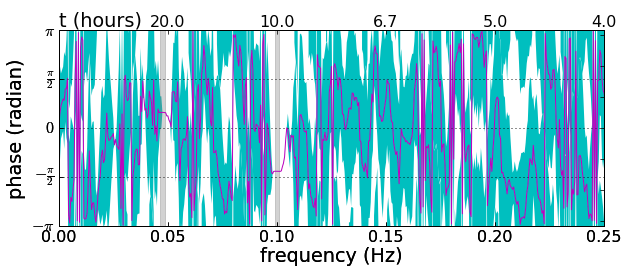

In [112]:
plt.figure(figsize=(9,4))
plt.rcParams.update({'axes.labelsize': 'large'})
ax = host_subplot(111, axes_class=AA.Axes)

ax.set_xlim([xlim_start,xlim_end])
ax.set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
ax.set_yticklabels(['$-\pi$', r'$-\frac{\pi}{2}$', r'$0$', r'$\frac{\pi}{2}$', r'$\pi$'])

ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('phase (radian)')
ax.set_title('t (hours)', loc='left')

ax2 = ax.twin() # ax2 is responsible for "top" axis and "right" axis
#ax2.set_xlabel('The Dependence of Phase-Delay on Frequency and Time (+ Phase Uncertainty Estimates via Monte Carlo Analysis)')
ax2.set_xticks([(0.05),(0.1),(0.15),(0.2), (0.25)])#0., .5*np.pi, np.pi, 1.5*np.pi, 2*np.pi])
ax2.set_xticklabels([str(1./0.05),str(1./0.1),str(round(1./0.15,1)),str(1./0.2),str(1./0.25)])
ax2.axis["right"].major_ticklabels.set_visible(False)
ax.grid(axis='y')

#ax.plot(f,phif, 'c', lw=1)
plt.axvspan(vspan_start1,vspan_end1, color='gray', alpha=0.35)
plt.axvspan(vspan_start2,vspan_end2, color='gray', alpha=0.35)

ax.set_xlim(xlim_start,xlim_end)
ax.set_ylim(-np.pi,np.pi)

plt.plot(f,ph, 'm', label='phase xy')

plt.fill_between(f,ph,(ph-phif),facecolor='c' ,edgecolor='c', lw=0.0)#, where=(ph-phif)>=-np.pi)
plt.fill_between(f,ph,(ph+phif),facecolor='c' ,edgecolor='c', lw=0.0)

plt.fill_between(f,(ph+2*np.pi),((ph+2*np.pi)-phif), where=(ph-phif)<=-np.pi,
                 facecolor='c' ,edgecolor='c', lw=0.0)
plt.fill_between(f,(ph-2*np.pi),((ph-2*np.pi)+phif), where=(ph+phif)>=np.pi,
                 facecolor='c' ,edgecolor='c', lw=0.0)

#plt.title('phase between x and y for all frequencies + uncertainty')
plt.gcf().tight_layout()
plt.savefig(r'C:\Users\lenovo.lenovo-PC.000\Documents\images_oral_defense//phase_uncertainty_x_y.png', dpi=400)

D:\Python27x64\lib\site-packages\ipykernel\__main__.py:1: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
D:\Python27x64\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
D:\Python27x64\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()
D:\Python27x64\lib\site-packages\ipykernel\__main__.py:4: RuntimeWarning: divide by zero encountered in true_divide


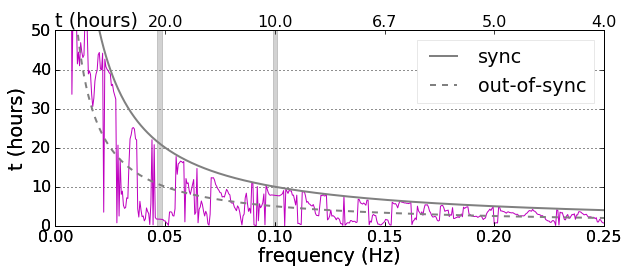

In [114]:
rad2time = ph/(2*np.pi*f)
mtcl2time = phif/(2*np.pi*f)
neg_time= np.where(rad2time<0)
dur_cycl = (1/f)
rad2time[neg_time] = rad2time[neg_time]+dur_cycl[neg_time]

plt.figure(figsize=(9,4))
plt.rcParams.update({'axes.labelsize': 'large'})
ax = host_subplot(111, axes_class=AA.Axes)

ax.fill_between(f,(rad2time+mtcl2time),(rad2time-mtcl2time), where=(((rad2time+mtcl2time)<dur_cycl)), 
             facecolor='c' ,edgecolor='c', lw=0.0 ,interpolate=True)
ax.fill_between(f,(rad2time-mtcl2time),dur_cycl, where=(((rad2time+mtcl2time)>dur_cycl)),
             facecolor='c' ,edgecolor='c', lw=0.0 ,interpolate=True)
ax.fill_between(f,(rad2time+mtcl2time)-dur_cycl, where=(((rad2time+mtcl2time)>0)),
             facecolor='c' ,edgecolor='c', lw=0.0 ,interpolate=True)
ax.fill_between(f,((rad2time-mtcl2time)+dur_cycl),dur_cycl, where=((rad2time-mtcl2time)<0), 
             facecolor='c' ,edgecolor='c', lw=0.0 ,interpolate=True)

p1 = plt.Rectangle((0, 0), 1, 1, fc='c', ec='c')
p2, = ax.plot(f, rad2time, color='m', label='Phase')
p3, = ax.plot(f, dur_cycl, color='gray', linestyle='-', lw=2, label='sync')
p4, = ax.plot(f, dur_cycl/2, color='gray', linestyle='--', lw=2, label='out-of-sync')

ax.set_xlim([xlim_start,xlim_end])
ax.set_ylim([0,50])

ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('t (hours)')
ax.set_title('t (hours)', loc='left')

p5 = plt.axvspan(vspan_start1,vspan_end1, color='gray', alpha=0.35)
plt.axvspan(vspan_start2,vspan_end2, color='gray', alpha=0.35)

ax2 = ax.twin() # ax2 is responsible for "top" axis and "right" axis
#ax2.set_xlabel('The Dependence of Phase-Delay on Frequency and Time (+ Phase Uncertainty Estimates via Monte Carlo Analysis)')
ax2.set_xticks([(0.05),(0.1),(0.15),(0.2), (0.25)])#0., .5*np.pi, np.pi, 1.5*np.pi, 2*np.pi])
ax2.set_xticklabels([str(1./0.05),str(1./0.1),str(round(1./0.15,1)),str(1./0.2),str(1./0.25)])
ax2.axis["right"].major_ticklabels.set_visible(False)

lg = plt.legend([p3,p4], ['sync','out-of-sync'], ncol=1)
lg.get_frame().set_ec('lightgray')
lg.get_frame().set_lw(0.5)
plt.grid(axis='y', zorder=0)

plt.gcf().tight_layout()
plt.savefig(r'C:\Users\lenovo.lenovo-PC.000\Documents\images_oral_defense//phase_uncertainty_hours_x_y.png', dpi=400)

# COMBI

In [ ]:
plt.figure(figsize=(10,8.55))
plt.rcParams.update({'axes.labelsize': 'large'})

ax = host_subplot(321, axes_class=AA.Axes)

#plt.figure(figsize=(14,5))
#plt.subplot(121)
ax.grid(axis='y')

p1, = ax.plot(t,x, 'k-', lw=1, label='TRMM')
p2, = ax.plot(t,y, 'k--', lw=1, label='NDVI')
ax.set_xlim(0,365)
ax.set_ylim(-0.2,0.2)
ax.set_yticks([-0.2,-0.1,0,0.1,0.2])

ax.set_ylabel('anomaly difference')
ax.set_xlabel('day of year')
ax.set_title('normalised anomaly timeseries')
lg = plt.legend([p1,p2], ['P','NDVI'], ncol=1)
lg.get_frame().set_ec('lightgray')
lg.get_frame().set_lw(0.5)




ax = host_subplot(322, axes_class=AA.Axes)
#ax = fig.add_subplot(121)

# aiaiaiai
ax.set_xlim([xlim_start,xlim_end])
ax.set_ylim([-120,50])
ax.set_xticks([(1/366),(1./(366./2)),(1./(366./3)),(1./(366./4))])
ax.set_xticklabels([str(0.0027),str(0.0055),str(0.0082),str(0.0109)])
ax.axhline(zorder=2, color='lightgray')#, alpha=1)
ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('phase (day)')
ax.set_title('t (month)', loc='left', fontsize=10)

#p5= plt.axvspan(vspan_start,vspan_end, color='gray', alpha=0.1, zorder=-1)
#axvspan(0.099,0.101, color='gray', alpha=0.1, zorder=0)

ax2 = ax.twin() # ax2 is responsible for "top" axis and "right" axis
ax2.set_xlabel('CSD P / NDVI', fontsize=25)
ax2.set_xticks([(1/366),(1./(366./2)),(1./(366./3)),(1./(366./4))])
ax2.set_xticklabels([str(12),str(6),str(4),str(3)])
ax2.axis["right"].major_ticklabels.set_visible(False)
ax2.xaxis.label.set_size(2)
# aiaiaiai

ax.grid(axis='y', zorder =1)
ax.plot(f,dB(cxy), 'g-', lw=1, zorder =4)
ax.axvspan(vspan_start,vspan_end, color='gray', alpha=0.35, zorder =3)
#plt.axvspan(0.099,0.101, color='gray', alpha=0.1)
#ax.set_xlim(xlim_start,xlim_end)
#plt.ylim(-5,35)

ax.set_ylabel('cross-power (10log10)') # regex: ($10log10$)
ax.set_xlabel('frequency (Hz)')
#ax.set_title('cross spectral density of x and y')
ax.set_yscale('symlog')
#plt.gcf().tight_layout()
#plt.savefig(r'D:\Downloads\Libraries_documents\HOME\Figures paper//NEW_cross_power.png', dpi=400)

ax = host_subplot(323, axes_class=AA.Axes)

# aiaiaiai
ax.set_xlim([xlim_start,xlim_end])

ax.set_xticks([(1/366),(1./(366./2)),(1./(366./3)),(1./(366./4))])
ax.set_xticklabels([str(0.0027),str(0.0055),str(0.0082),str(0.0109)])

ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('phase (day)')
ax.set_title('t (month)', loc='left', fontsize=10)

#p5= plt.axvspan(vspan_start,vspan_end, color='gray', alpha=0.1, zorder=-1)
#axvspan(0.099,0.101, color='gray', alpha=0.1, zorder=0)

ax2 = ax.twin() # ax2 is responsible for "top" axis and "right" axis
ax2.set_xlabel('coherence P / NDVI')
ax2.set_xticks([(1/366),(1./(366./2)),(1./(366./3)),(1./(366./4))])
ax2.set_xticklabels([str(12),str(6),str(4),str(3)])
ax2.axis["right"].major_ticklabels.set_visible(False)
ax2.xaxis.label.set_size(2)
# aiaiaiai

# plt.subplot(122)
ax.grid(axis='y')
ax.set_ylim([0,1.01])
ax.plot(f,coh, 'y')

ax.axvspan(vspan_start,vspan_end, color='gray', alpha=0.35)
# #plt.axvspan(0.099,0.101, color='gray', alpha=0.1)
ax.set_xlim(xlim_start,xlim_end)
# plt.ylim(0,1.01)

ax.set_ylabel('coherence')
ax.set_xlabel('frequency (Hz)')
#ax.set_title()

## PLOT 7
#plt.figure(figsize=(5,2.85))
#plt.rcParams.update({'axes.labelsize': 'large'})
ax = host_subplot(324, axes_class=AA.Axes)

# aiaiaiai
ax.set_xlim([xlim_start,xlim_end])

ax.set_xticks([(1/366),(1./(366./2)),(1./(366./3)),(1./(366./4))])
ax.set_xticklabels([str(0.0027),str(0.0055),str(0.0082),str(0.0109)])
#ax.set_xticks([(1/366),(1./(366./2)),(1./(366./3)),(1./(366./4))],[str(0.0027),str(0.0055),str(0.0082),str(0.0109)])
ax.set_yticks([0,1./4*np.pi, np.pi/2, 3./4*np.pi,np.pi])
ax.set_yticklabels([r'$0$', r'$\frac{1}{4}\pi$', r'$\frac{\pi}{2}$', r'$\frac{3}{4}\pi$', 
                    r'$\pi$'])


ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('phase (day)')
ax.set_title('t (month)', loc='left', fontsize=10)

#p5= plt.axvspan(vspan_start,vspan_end, color='gray', alpha=0.1, zorder=-1)
#axvspan(0.099,0.101, color='gray', alpha=0.1, zorder=0)

ax2 = ax.twin() # ax2 is responsible for "top" axis and "right" axis
ax2.set_xlabel('phase uncertainty P / NDVI')
ax2.set_xticks([(1/366),(1./(366./2)),(1./(366./3)),(1./(366./4))])
ax2.set_xticklabels([str(12),str(6),str(4),str(3)])
ax2.axis["right"].major_ticklabels.set_visible(False)
ax2.xaxis.label.set_size(2)
#plt.subplot(337)
ax.grid(axis='y')

ax.plot(f,phif, 'c', lw=1)
ax.axvspan(vspan_start,vspan_end, color='gray', alpha=0.35)

ax.set_xlim(xlim_start,xlim_end)
ax.set_ylim(-0.05,3.2)

ax.set_ylabel('phase uncert (radian)')
ax.set_xlabel('frequency (Hz)')
#ax.set_title('')

#plt.gcf().tight_layout()
#plt.savefig(r'D:\Downloads\Libraries_documents\HOME\Figures paper//NEW_phase_uncertain.png', dpi=400)

#plt.figure(figsize=(5,2.85))
#plt.rcParams.update({'axes.labelsize': 'large'})
ax = host_subplot(325, axes_class=AA.Axes)

# aiaiaiai
ax.set_xlim([xlim_start,xlim_end])

ax.set_xticks([(1/366),(1./(366./2)),(1./(366./3)),(1./(366./4))])
ax.set_xticklabels([str(0.0027),str(0.0055),str(0.0082),str(0.0109)])
#ax.set_xticks([(1/366),(1./(366./2)),(1./(366./3)),(1./(366./4))],[str(0.0027),str(0.0055),str(0.0082),str(0.0109)])
ax.set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
ax.set_yticklabels(['$-\pi$', r'$-\frac{\pi}{2}$', r'$0$', r'$\frac{\pi}{2}$', r'$\pi$'])


#ax.set_yticks([0,1./4*np.pi, np.pi/2, 3./4*np.pi,np.pi])
#ax.set_yticklabels([r'$0$', r'$\frac{1}{4}\pi$', r'$\frac{\pi}{2}$', r'$\frac{3}{4}\pi$', 
#                    r'$\pi$'])


ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('phase (day)')
ax.set_title('t (month)', loc='left', fontsize=10)

#p5= plt.axvspan(vspan_start,vspan_end, color='gray', alpha=0.1, zorder=-1)
#axvspan(0.099,0.101, color='gray', alpha=0.1, zorder=0)

ax2 = ax.twin() # ax2 is responsible for "top" axis and "right" axis
ax2.set_xlabel('phase spectrum P / NDVI + uncertainty ')
ax2.set_xticks([(1/366),(1./(366./2)),(1./(366./3)),(1./(366./4))])
ax2.set_xticklabels([str(12),str(6),str(4),str(3)])
ax2.axis["right"].major_ticklabels.set_visible(False)
ax2.xaxis.label.set_size(2)
#plt.subplot(337)
ax.grid(axis='y')

#ax.plot(f,phif, 'c', lw=1)
ax.axvspan(vspan_start,vspan_end, color='gray', alpha=0.35)

ax.set_xlim(xlim_start,xlim_end)
#ax.set_ylim(-0.05,3.2)
ax.set_ylim(-np.pi,np.pi)

#ax.set_ylabel('phase uncert (radian)')
ax.set_xlabel('frequency (Hz)')
#ax.set_title('')


#plt.figure(figsize=(14,5))
#plt.subplot(121)
#plt.grid(axis='y')
plt.plot(f,ph, 'm')
#plt.axvspan(vspan_start,vspan_end, color='gray', alpha=0.1)
#plt.axvspan(0.099,0.101, color='gray', alpha=0.1)

plt.fill_between(f,ph,(ph-phif),facecolor='c' ,edgecolor='c', lw=0.0)#, where=(ph-phif)>=-np.pi)
plt.fill_between(f,ph,(ph+phif),facecolor='c' ,edgecolor='c', lw=0.0)

plt.fill_between(f,(ph+2*np.pi),((ph+2*np.pi)-phif), where=(ph-phif)<=-np.pi,
                 facecolor='c' ,edgecolor='c', lw=0.0)
plt.fill_between(f,(ph-2*np.pi),((ph-2*np.pi)+phif), where=(ph+phif)>=np.pi,
                 facecolor='c' ,edgecolor='c', lw=0.0)


#plt.xlim(xlim_start,xlim_end)


ax.set_ylabel('phase (radian)')
#ax.set_xlabel('frequency (Hz)')
#plt.title('phase between x and y for all frequencies + uncertainty')
#plt.gcf().tight_layout()
#plt.savefig(r'D:\Downloads\Libraries_documents\HOME\Figures paper//NEW_phasespectrum_uncertain.png', dpi=400)

## PLOT 9
rad2time = ph/(2*np.pi*f)
mtcl2time = phif/(2*np.pi*f)
neg_time= np.where(rad2time<0)
dur_cycl = (1/f)
rad2time[neg_time] = rad2time[neg_time]+dur_cycl[neg_time]


## PLOT 7
#plt.figure(figsize=(5,2.85))
#plt.rcParams.update({'axes.labelsize': 'large'})
ax = host_subplot(326, axes_class=AA.Axes)

p1 = plt.Rectangle((0, 0), 1, 1, fc='c', ec='c')
p2, = ax.plot(f, rad2time, color='m', zorder=5, label='Phase')
p3, = ax.plot(f, dur_cycl, color='gray', linestyle='-.', zorder=5, label='Period')
p4, = ax.plot(f, dur_cycl/2, color='gray', linestyle='--', zorder=5, label='Halve period')

ax.fill_between(f,(rad2time+mtcl2time),(rad2time-mtcl2time), where=(((rad2time+mtcl2time)<dur_cycl)), 
             facecolor='c' ,edgecolor='c', lw=0.0 ,interpolate=True, zorder=4)
ax.fill_between(f,(rad2time-mtcl2time),dur_cycl, where=(((rad2time+mtcl2time)>dur_cycl)),
             facecolor='c' ,edgecolor='c', lw=0.0 ,interpolate=True, zorder=4)
ax.fill_between(f,(rad2time+mtcl2time)-dur_cycl, where=(((rad2time+mtcl2time)>0)),
             facecolor='c' ,edgecolor='c', lw=0.0 ,interpolate=True, zorder=4)
ax.fill_between(f,((rad2time-mtcl2time)+dur_cycl),dur_cycl, where=((rad2time-mtcl2time)<0), 
             facecolor='c' ,edgecolor='c', lw=0.0 ,interpolate=True, zorder=4)

ax.set_xlim([xlim_start,xlim_end])
ax.set_ylim([0,365])
ax.set_xticks([(1/366),(1./(366./2)),(1./(366./3)),(1./(366./4))])
ax.set_xticklabels([str(0.0027),str(0.0055),str(0.0082),str(0.0109)])

ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('time-lag(days)')
ax.set_title('t (month)', loc='left', fontsize=10)

p5= plt.axvspan(vspan_start,vspan_end, color='gray', alpha=0.35, zorder=-1)
#axvspan(0.099,0.101, color='gray', alpha=0.1, zorder=0)

ax2 = ax.twin() # ax2 is responsible for "top" axis and "right" axis
ax2.set_xlabel('time-lag P / NDVI + uncertainty')
ax2.set_xticks([(1/366),(1./(366./2)),(1./(366./3)),(1./(366./4))])
ax2.set_xticklabels([str(12),str(6),str(4),str(3)])
ax2.axis["right"].major_ticklabels.set_visible(False)
ax2.xaxis.label.set_size(2)


lg = plt.legend([p3,p4], ['sync','out-of-sync'], ncol=1)
lg.get_frame().set_ec('lightgray')
lg.get_frame().set_lw(0.5)
plt.grid(axis='y', zorder=0 )

plt.tight_layout()
#plt.gcf().tight_layout()
plt.savefig(r'D:\Downloads\Libraries_documents\HOME\Figures paper//NEW_all.png', dpi=400, pad_inches=0.1)


Cross spectral density shows single peak for 0.1 Hz and the other peak of 0.047 Hz is still visible but weaker. In the coherence plot its visible there is a clear coherence for the 0.1 Hz peak and the two timeseries are near 0 coherent for the frequency of 0.047 Hz. Next we plot the phase spectrum and phase uncertainty seperately.

In [ ]:
plt.figure(figsize=(14,5))
plt.subplot(121)
plt.grid(axis='y')

plt.plot(f,ph, 'm', lw=1)
plt.axvspan(vspan_start,vspan_end, color='gray', alpha=0.35)
#plt.axvspan(0.099,0.101, color='gray', alpha=0.1)
plt.xlim(xlim_start,xlim_end)
plt.ylim(-np.pi,np.pi)

plt.ylabel('phase (radian, bounded [$-{\pi}-{\pi}$])')
plt.xlabel('frequency (Hz)')
plt.title('phase between x and y for all frequencies')
plt.gcf().tight_layout()

plt.subplot(122)
plt.grid(axis='y')

plt.plot(f,phif, 'c', lw=1)
plt.axvspan(vspan_start,vspan_end, color='gray', alpha=0.35)
#plt.axvspan(0.099,0.101, color='gray', alpha=0.1)
plt.xlim(xlim_start,xlim_end)
plt.ylim(-0.05,3.2)

plt.ylabel('phase uncertainty (radian, bounded [$0-{\pi}$])')
plt.xlabel('frequency (Hz)')
plt.title('phase uncertainty between x and y for all frequencies')
plt.gcf().tight_layout()

Phase of frequency 0.1 Hz is stable at 1 radian. Phase uncertainty shows high uncertainty for all frequencies excempt frequency corresponding to 0.1 Hz. So by combining the phase and phase uncertainty we get last two plots with phase in radian and phase in time domain units, which are hours this time.

In [ ]:
plt.figure(figsize=(14,5))
plt.subplot(121)
plt.grid(axis='y')
plt.plot(f,ph, 'm')
plt.axvspan(vspan_start,vspan_end, color='gray', alpha=0.1)
#plt.axvspan(0.099,0.101, color='gray', alpha=0.1)

plt.fill_between(f,ph,(ph-phif),facecolor='c' ,edgecolor='c', lw=0.0)#, where=(ph-phif)>=-np.pi)
plt.fill_between(f,ph,(ph+phif),facecolor='c' ,edgecolor='c', lw=0.0)

plt.fill_between(f,(ph+2*np.pi),((ph+2*np.pi)-phif), where=(ph-phif)<=-np.pi,
                 facecolor='c' ,edgecolor='c', lw=0.0)
plt.fill_between(f,(ph-2*np.pi),((ph-2*np.pi)+phif), where=(ph+phif)>=np.pi,
                 facecolor='c' ,edgecolor='c', lw=0.0)


plt.xlim(xlim_start,xlim_end)
plt.ylim(-np.pi,np.pi)

plt.ylabel('phase (radian, bounded [$-{\pi}-{\pi}$])')
plt.xlabel('frequency (Hz)')
plt.title('phase between x and y for all frequencies + uncertainty')
plt.gcf().tight_layout()

from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA

rad2time = ph/(2*np.pi*f)
mtcl2time = phif/(2*np.pi*f)
neg_time= np.where(rad2time<0)
dur_cycl = (1/f)
rad2time[neg_time] = rad2time[neg_time]+dur_cycl[neg_time]


ax = host_subplot(122, axes_class=AA.Axes)

p1 = plt.Rectangle((0, 0), 1, 1, fc='c', ec='c')
p2, = ax.plot(f, rad2time, color='m', zorder=5, label='Phase')
p3, = ax.plot(f, dur_cycl, color='gray', linestyle='-.', zorder=5, label='Period')
p4, = ax.plot(f, dur_cycl/2, color='gray', linestyle='--', zorder=5, label='Halve period')

ax.fill_between(f,(rad2time+mtcl2time),(rad2time-mtcl2time), where=(((rad2time+mtcl2time)<dur_cycl)), 
             facecolor='c' ,edgecolor='c', lw=0.0 ,interpolate=True, zorder=4)
ax.fill_between(f,(rad2time-mtcl2time),dur_cycl, where=(((rad2time+mtcl2time)>dur_cycl)),
             facecolor='c' ,edgecolor='c', lw=0.0 ,interpolate=True, zorder=4)
ax.fill_between(f,(rad2time+mtcl2time)-dur_cycl, where=(((rad2time+mtcl2time)>0)),
             facecolor='c' ,edgecolor='c', lw=0.0 ,interpolate=True, zorder=4)
ax.fill_between(f,((rad2time-mtcl2time)+dur_cycl),dur_cycl, where=((rad2time-mtcl2time)<0), 
             facecolor='c' ,edgecolor='c', lw=0.0 ,interpolate=True, zorder=4)

ax.set_xlim([xlim_start,xlim_end])
ax.set_ylim([0,366])
#ax.set_xticks([(1/366),(1./(366./2)),(1./(366./3)),(1./(366./4))])

ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('phase (days)')
ax.set_title('time (days)', loc='left', fontsize=10)

p5= plt.axvspan(vspan_start,vspan_end, color='gray', alpha=0.1, zorder=-1)
#axvspan(0.099,0.101, color='gray', alpha=0.1, zorder=0)

ax2 = ax.twin() # ax2 is responsible for "top" axis and "right" axis
ax2.set_xlabel('phase between x and y for all frequencies + uncertainty')
ax2.set_xticks([0.05,0.1,0.15,0.2])#0., .5*np.pi, np.pi, 1.5*np.pi, 2*np.pi])
ax2.set_xticklabels([str(round(1./0.05, 1)),str(round(1./0.1,1)),str(round(1./0.15,1)),str(round(1./0.2,1))])
ax2.axis["right"].major_ticklabels.set_visible(False)
ax2.xaxis.label.set_size(2)

plt.legend([p2,p3,p4,p1,p5], ['phase-delay','single period','halve period','phase uncertainty estimates', 'frequencies of interest'])
plt.grid(axis='y', zorder=0 )

plt.tight_layout()

plt.show()

For plot on the right matplotlib shows some glimpses as he found it difficult to plot it perfectly. It's forgiven.
So to get some results out of the plot. Apply a bandpass filter between 0.099 and 0.101 Hz to see the phase in radian and in hour. 

In [ ]:
# frequency index
f_lb = vspan_start
f_ub = vspan_end
f_ix = np.where((f > f_lb) * (f < f_ub))[0]
p_r2t = np.mean(rad2time[f_ix], -1)
p_ph = np.mean(ph[f_ix], -1)
print 'phase in radian is', round(p_ph,2)   
print 'which correspond to',round(p_r2t,2), 'days (',(365-round(p_r2t,2))*-1,')'
    

In [ ]:
#x_  = 4 * np.sin(2*(np.pi/10)*t)
#y_  = 4 * np.sin(2*(np.pi/10)*t+1)
y0  = 0.10 * np.sin(2*(np.pi/(1./0.0027))*t+1.2)
y1  = 0.10 * np.sin(2*(np.pi/(1./0.0027))*t+1.2-p_ph)
#x1 = 4 * np.sin(2*(np.pi/(1./0.1)*t-p_ph))#ps)
#y1 = 4 * np.sin(2*(np.pi/(1./0.1)*t))
plt.figure(figsize=(7,5))
#plt.subplot(121)
plt.grid()

p1, = plt.plot(t,x, 'k-', alpha=0.3,lw=1, label='precipitation mean')
p2, = plt.plot(t,y, 'k--', alpha=0.3, lw=1, label='NDVI mean')

#plt.plot(t,x1, 'r', lw=1, label='x1')
p3, = plt.plot(t,y0, 'c', lw=1.4, label='annual period precipitation')
p4, = plt.plot(t,y1, 'm--', lw=1.4, label='annual period NDVI')
#plt.plot(t,x2, 'b-', lw=1, label='x2')
#plt.plot(t,y1, 'g.', lw=1, label='y1')
#plt.plot(t,y2, 'm-', lw=1, label='y2')

plt.xlim(0,365)

plt.ylabel('normalised anomaly')
plt.xlabel('day of year')
plt.title('anomaly timeseries + annual period')
plt.ylim(-0.25,0.15)
leg = plt.legend([p1,p3,p2,p4],['precipitation mean','annual period precipitation',
                                'NDVI mean', 'annual period NDVI'],ncol=2, loc=3)
leg.get_frame().set_lw(0.5)
leg.get_frame().set_ec('lightgray')
#leg.get_frame().set_alpha(0.5)
plt.tight_layout()
#plt.savefig(r'C:\Users\lenovo\Documents\HOME\Figures paper//y_anomaly_annual_period', dpi=400)

That's nice, let's throw everything in one plot. Just for fun

In [ ]:
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA

plt.figure(figsize=(14,7.5))

## PLOT 1
plt.subplot(331)
plt.grid(axis='y')

plt.plot(t,x, 'k-', lw=1, label='x')
plt.plot(t,y, 'k--', lw=1, label='y')

plt.xlim(0,364)
plt.ylim(-0.2,0.2)
plt.yticks([-0.2,-0.1,0,0.1,0.2])
plt.ylabel('normalised anomaly')
plt.xlabel('day of year')
plt.title('anomaly timeseries')
leg = plt.legend(loc=3, frameon=True, ncol=2)
leg.get_frame().set_edgecolor('lightgray')
leg.get_frame().set_lw(0.5)

## PLOT 2
plt.subplot(332)
plt.grid(axis='y')

plt.plot(f,dB(fkx), 'r-', lw=1)
plt.axvspan(vspan_start,vspan_end, color='gray', alpha=0.1)
plt.xticks([(1/366),(1./(366./2)),(1./(366./3)),(1./(366./4))],[str(0.0027),str(0.0055),str(0.0082),str(0.0109)])
plt.xlim(xlim_start,xlim_end)
#plt.ylim(-5,35)

plt.ylabel('power ($10log10$)')
plt.xlabel('frequency (Hz)')
plt.title('power spectrum x')
#plt.gcf().tight_layout()

## PLOT 3
plt.subplot(333)
plt.grid(axis='y')
plt.plot(f,dB(fky), 'b-', lw=1)
plt.axvspan(vspan_start,vspan_end, color='gray', alpha=0.1)
plt.xticks([(1/366),(1./(366./2)),(1./(366./3)),(1./(366./4))],[str(0.0027),str(0.0055),str(0.0082),str(0.0109)])
plt.xlim(xlim_start,xlim_end)
#plt.ylim(-5,35)

plt.ylabel('power ($10log10$)')
plt.xlabel('frequency (Hz)')
plt.title('power spectrum y')

## PLOT 4
plt.subplot(334)
plt.grid(axis='y')

plt.plot(f,dB(cxy), 'g-', lw=1)
plt.axvspan(vspan_start,vspan_end, color='gray', alpha=0.1)
plt.xticks([(1/366),(1./(366./2)),(1./(366./3)),(1./(366./4))],[str(0.0027),str(0.0055),str(0.0082),str(0.0109)])
plt.xlim(xlim_start,xlim_end)
#plt.ylim(-5,35)

plt.ylabel('cross-power ($10log10$)')
plt.xlabel('frequency (Hz)')
plt.title('cross-spectrum x/y')
#plt.gcf().tight_layout()

## PLOT 5
plt.subplot(335)
plt.grid(axis='y')

plt.plot(f,coh, 'y')

plt.axvspan(vspan_start,vspan_end, color='gray', alpha=0.1)
plt.xticks([(1/366),(1./(366./2)),(1./(366./3)),(1./(366./4))],[str(0.0027),str(0.0055),str(0.0082),str(0.0109)])
plt.xlim(xlim_start,xlim_end)
plt.ylim(0,1.01)

plt.ylabel('coherence')
plt.xlabel('frequency (Hz)')
plt.title('coherence x/y')


## PLOT 6
plt.subplot(336)
plt.grid(axis='y')

plt.plot(f,ph, 'm', lw=1)
plt.axvspan(vspan_start,vspan_end, color='gray', alpha=0.1)
plt.yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],
           ['$-\pi$', r'$-\frac{\pi}{2}$', r'$0$', r'$\frac{\pi}{2}$', r'$\pi$'])
plt.xticks([(1/366),(1./(366./2)),(1./(366./3)),(1./(366./4))],[str(0.0027),str(0.0055),str(0.0082),str(0.0109)])
plt.xlim(xlim_start,xlim_end)
plt.ylim(-np.pi,np.pi)

plt.ylabel('phase (radian)')
plt.xlabel('frequency (Hz)')
plt.title('phase spectrum x/y')
#plt.gcf().tight_layout()

## PLOT 7
plt.subplot(337)
plt.grid(axis='y')

plt.plot(f,phif, 'c', lw=1)
plt.axvspan(vspan_start,vspan_end, color='gray', alpha=0.1)
plt.yticks([0,1./4*np.pi, np.pi/2, 3./4*np.pi,np.pi],
           [r'$0$', r'$\frac{1}{4}\pi$', r'$\frac{\pi}{2}$', r'$\frac{3}{4}\pi$', r'$\pi$'])
plt.xticks([(1/366),(1./(366./2)),(1./(366./3)),(1./(366./4))],[str(0.0027),str(0.0055),str(0.0082),str(0.0109)])
plt.xlim(xlim_start,xlim_end)
plt.ylim(-0.05,3.2)

plt.ylabel('phase uncert (radian)')
plt.xlabel('frequency (Hz)')
plt.title('phase uncertainty x/y')

## PLOT 8
plt.subplot(338)
plt.grid(axis='y')
plt.plot(f,ph, 'm')

plt.fill_between(f,ph,(ph-phif),facecolor='c' ,edgecolor='c', lw=0.0)#, where=(ph-phif)>=-np.pi)
plt.fill_between(f,ph,(ph+phif),facecolor='c' ,edgecolor='c', lw=0.0)

plt.fill_between(f,(ph+2*np.pi),((ph+2*np.pi)-phif), where=(ph-phif)<=-np.pi,
                 facecolor='c' ,edgecolor='c', lw=0.0)
plt.fill_between(f,(ph-2*np.pi),((ph-2*np.pi)+phif), where=(ph+phif)>=np.pi,
                 facecolor='c' ,edgecolor='c', lw=0.0)

plt.axvspan(vspan_start,vspan_end, color='gray', alpha=0.1)
plt.yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],
           ['$-\pi$', r'$-\frac{\pi}{2}$', r'$0$', r'$\frac{\pi}{2}$', r'$\pi$'])

plt.xticks([(1/366),(1./(366./2)),(1./(366./3)),(1./(366./4))],[str(0.0027),str(0.0055),str(0.0082),str(0.0109)])


plt.xlim(xlim_start,xlim_end)
plt.ylim(-np.pi,np.pi)

plt.ylabel('phase (radian)')
plt.xlabel('frequency (Hz)')
plt.title('phase spectrum x/y + uncertainty')
#plt.gcf().tight_layout()



## PLOT 9
rad2time = ph/(2*np.pi*f)
mtcl2time = phif/(2*np.pi*f)
neg_time= np.where(rad2time<0)
dur_cycl = (1/f)
rad2time[neg_time] = rad2time[neg_time]+dur_cycl[neg_time]


ax = host_subplot(339, axes_class=AA.Axes)

p1 = plt.Rectangle((0, 0), 1, 1, fc='c', ec='c')
p2, = ax.plot(f, rad2time, color='m', zorder=5, label='Phase')
p3, = ax.plot(f, dur_cycl, color='gray', linestyle='-.', zorder=5, label='Period')
p4, = ax.plot(f, dur_cycl/2, color='gray', linestyle='--', zorder=5, label='Halve period')

ax.fill_between(f,(rad2time+mtcl2time),(rad2time-mtcl2time), where=(((rad2time+mtcl2time)<dur_cycl)), 
             facecolor='c' ,edgecolor='c', lw=0.0 ,interpolate=True, zorder=4)
ax.fill_between(f,(rad2time-mtcl2time),dur_cycl, where=(((rad2time+mtcl2time)>dur_cycl)),
             facecolor='c' ,edgecolor='c', lw=0.0 ,interpolate=True, zorder=4)
ax.fill_between(f,(rad2time+mtcl2time)-dur_cycl, where=(((rad2time+mtcl2time)>0)),
             facecolor='c' ,edgecolor='c', lw=0.0 ,interpolate=True, zorder=4)
ax.fill_between(f,((rad2time-mtcl2time)+dur_cycl),dur_cycl, where=((rad2time-mtcl2time)<0), 
             facecolor='c' ,edgecolor='c', lw=0.0 ,interpolate=True, zorder=4)

ax.set_xlim([xlim_start,xlim_end])
ax.set_ylim([0,365])
ax.set_xticks([(1/366),(1./(366./2)),(1./(366./3)),(1./(366./4))])
ax.set_xticklabels([str(0.0027),str(0.0055),str(0.0082),str(0.0109)])

ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('phase (day)')
ax.set_title('t (month)', loc='left', fontsize=10)

p5= plt.axvspan(vspan_start,vspan_end, color='gray', alpha=0.1, zorder=-1)
#axvspan(0.099,0.101, color='gray', alpha=0.1, zorder=0)

ax2 = ax.twin() # ax2 is responsible for "top" axis and "right" axis
ax2.set_xlabel('phase spectrum x/y + uncertainty')
ax2.set_xticks([(1/366),(1./(366./2)),(1./(366./3)),(1./(366./4))])
ax2.set_xticklabels([str(12),str(6),str(4),str(3)])
ax2.axis["right"].major_ticklabels.set_visible(False)
ax2.xaxis.label.set_size(2)


lg = plt.legend([p3,p4], ['single period','halve period'], ncol=1)
lg.get_frame().set_ec('lightgray')
lg.get_frame().set_lw(0.5)
plt.grid(axis='y', zorder=0 )

plt.gcf().tight_layout()
#plt.savefig(r'C:\Users\lenovo\Documents\HOME\Figures paper//y_psdcsdcohphase.png', dpi=400)

# frequency index
f_lb = vspan_start
f_ub = vspan_end
f_ix = np.where((f > f_lb) * (f < f_ub))[0]
p_r2t = np.mean(rad2time[f_ix], -1)
p_ph = np.mean(ph[f_ix], -1)
print 'phase in radian is', round(p_ph,2)
print 'which correspond to', round(p_r2t,2), 'day'